In [69]:
%pip install yfinance pandas_ta scikit-learn matplotlib statsmodels


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\sparsh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [70]:

import yfinance as yf
import statsmodels.api as sm

stockOne = 'NLCINDIA.NS'
stockTwo = 'NTPC.NS'

df = yf.download([stockOne, stockTwo], start="2000-01-01")['Close'].dropna()

print(df.head())

[*********************100%***********************]  2 of 2 completed

Ticker      NLCINDIA.NS    NTPC.NS
Date                              
2004-11-05    29.077206  31.995462
2004-11-08    28.569916  31.847242
2004-11-09    27.924257  31.889587
2004-11-10    27.970379  31.783709
2004-11-11    27.901201  31.529610


In [71]:
"""
# Before moving to another step of using OLS to find beta. It is important to identify the dependent and independent stock.

Say you are analyzing:
- Stock A: ICICIBANK (stable, large-cap, low volatility)
- Stock B: HDFCBANK (more volatile)

Wrong Way:
-----------
- ICICIBANK = alpha + beta * HDFCBANK
- You're trying to model how the stable stock depends on the noisy one.

This gives:
- Poor beta
- Non-stationary spread
- Bad trading signals

Right Way:
-----------
- HDFCBANK = alpha + beta * ICICIBANK
- You're modeling how the noisier stock reacts to the stable one.

This gives:
- Accurate hedge ratio (β)
- Clean, mean-reverting spread
- Reliable entry/exit signals
"""

dailyReturns = df.pct_change().dropna()

volatilityStockOne = dailyReturns[stockOne].std()
volatilityStockTwo = dailyReturns[stockTwo].std()

dependentStock = None
independentStock = None

if volatilityStockOne > volatilityStockTwo:
  dependentStock = stockOne
  independentStock = stockTwo
else:
  dependentStock = stockTwo
  independentStock = stockOne

print(f'Dependent Stock = {dependentStock}, IndependentStock = {independentStock}')


Dependent Stock = NLCINDIA.NS, IndependentStock = NTPC.NS


In [72]:
# Using OLS to find the value of beta

X = sm.add_constant(df[independentStock])
model = sm.OLS(df[dependentStock], X).fit()
beta = model.params[independentStock]
print(f'Beta = {beta}')


# Now as we already found beta, we have to find the spread which is given by
# spread = stockOne - beta * stockTwo

# We could also calculate the value of spread as stockOne - stockTwo but
# that would not be sufficient, because this works only if both have similar price scales and volatilities — which is rare.
# Using beta the spread is now a stationary series (ideally), suitable for statistical trading.
spread = df[dependentStock] - beta * df[independentStock]


Beta = 0.675446160212734


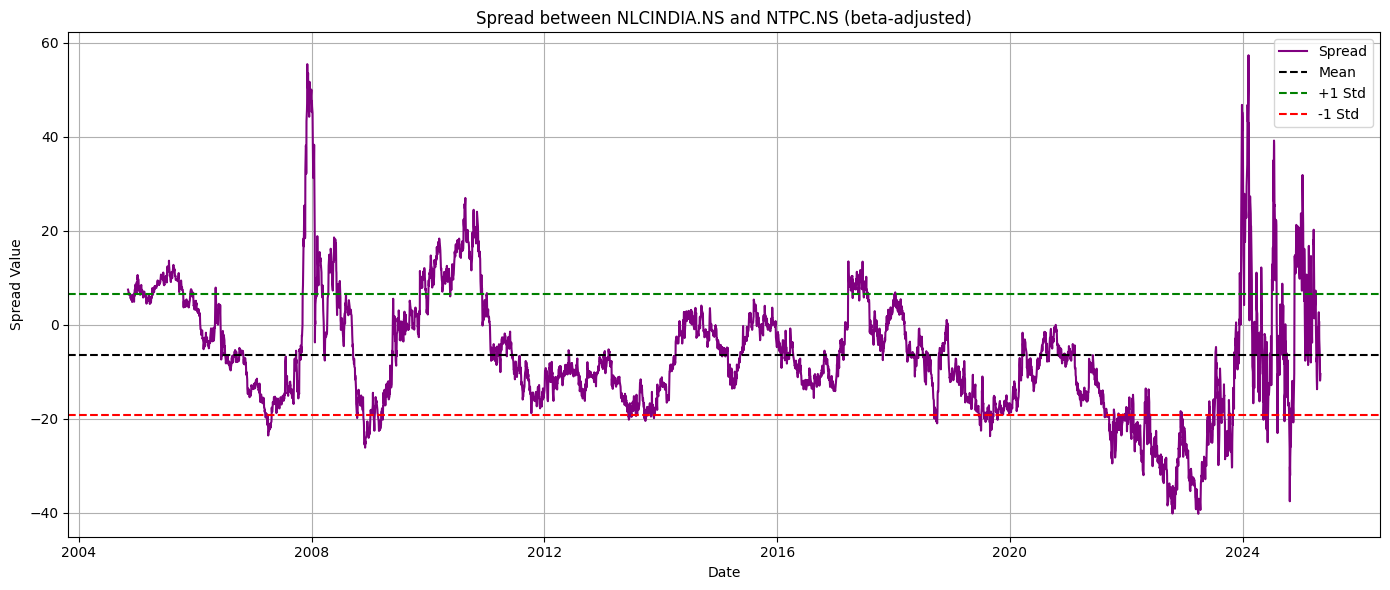

In [73]:


# Plotting the spread 
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(spread, label='Spread', color='purple', linewidth=1.5)
plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean')
plt.axhline(spread.mean() + spread.std(), color='green', linestyle='--', label='+1 Std')
plt.axhline(spread.mean() - spread.std(), color='red', linestyle='--', label='-1 Std')
plt.title(f'Spread between {stockOne} and {stockTwo} (beta-adjusted)')
plt.xlabel('Date')
plt.ylabel('Spread Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
# Proceed with ADFS and KPSS tests

from statsmodels.tsa.stattools import adfuller, kpss

adf_p_value = adfuller(spread)[1]

kpss_p_value = kpss(spread, regression='c')[1]

print(f"ADF p-value: {adf_p_value}")
print(f"KPSS p-value: {kpss_p_value}")
if adf_p_value < 0.05 and kpss_p_value > 0.05:
  print("The spread is stationary. Proceed with trading.")
else:
  print("The spread is not stationary. Do not trade this pair.")


ADF p-value: 9.929433583966058e-05
KPSS p-value: 0.01
The spread is not stationary. Do not trade this pair.


C:\Users\sparsh\AppData\Local\Temp\ipykernel_4480\2587289548.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_result = kpss(spread, regression='c')[1]
